# LSTM
[資料來源](https://www.finlab.tw/%E7%94%A8%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%B9%AB%E4%BD%A0%E8%A7%A3%E6%9E%90K%E7%B7%9A%E5%9C%96%EF%BC%81/)

In [30]:
import pandas as pd

foxconndf= pd.read_csv('./daily_stock_3535_2.csv')

In [90]:
from sklearn import preprocessing

def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['change'] = min_max_scaler.fit_transform(df.change.values.reshape(-1,1))
    newdf['next_open'] = min_max_scaler.fit_transform(df.next_open.values.reshape(-1,1))
    newdf = newdf.set_index(pd.to_datetime(newdf.ts, unit='s'))
    newdf = newdf.drop(['ts'], axis=1)
    return newdf

foxconndf_norm= normalize(foxconndf)

In [91]:
foxconndf_norm = foxconndf_norm
foxconndf_norm.head()

,high,low,open,close,change,transaction,next_open
ts,,,,,,,
2010-01-04,0.554993,0.564347,0.574442,0.564508,0.510791,1057,0.563531
2010-01-05,0.550169,0.544316,0.563531,0.533133,0.338129,613,0.528371
2010-01-06,0.518813,0.545568,0.528371,0.536898,0.539568,311,0.558681
2010-01-07,0.554993,0.576865,0.558681,0.584588,0.791367,2342,0.592629
2010-01-08,0.569465,0.564347,0.592629,0.569528,0.431655,1655,0.575655


In [112]:
import numpy as np

def data_helper(df, time_frame):
    
    # 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
    number_features = len(df.columns)

    # 將dataframe 轉成 numpy array
    datavalue = df.values

    result = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance
    
    result = np.array(result)
    number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料
    
    x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案

    # 測試資料
    x_test = result[int(number_train):, :-1]
    y_test = result[int(number_train):, -1][:,-1]
    
    # 將資料組成變好看一點
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

    return [x_train, y_train, x_test, y_test]

# 以20天為一區間進行股價預測
X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, 1)



In [208]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras

def build_model(input_length, input_dim):
    d = 0.3
    model = Sequential()

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

    return model

# 20天、5維
model = build_model( 1, 7 )

In [209]:
model.fit( X_train, y_train, batch_size=70, epochs=140, validation_split=0.1, verbose=1)

Train on 1872 samples, validate on 208 samples
Epoch 1/140
1872/1872 [==============================] - 5s 3ms/step - loss: 0.0784 - acc: 5.3419e-04 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 2/140
1872/1872 [==============================] - 0s 265us/step - loss: 0.0441 - acc: 5.3419e-04 - val_loss: 0.0116 - val_acc: 0.0000e+00
Epoch 3/140
1872/1872 [==============================] - 0s 252us/step - loss: 0.0393 - acc: 5.3419e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 4/140
1872/1872 [==============================] - 0s 247us/step - loss: 0.0341 - acc: 5.3419e-04 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 5/140
1872/1872 [==============================] - 0s 252us/step - loss: 0.0287 - acc: 5.3419e-04 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 6/140
1872/1872 [==============================] - 0s 245us/step - loss: 0.0292 - acc: 5.3419e-04 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 7/140
1872/1872 [==============================] - 0s 246us/step - loss: 0.0227

Epoch 57/140
1872/1872 [==============================] - 0s 263us/step - loss: 0.0065 - acc: 0.0011 - val_loss: 5.1665e-04 - val_acc: 0.0000e+00
Epoch 58/140
1872/1872 [==============================] - 0s 232us/step - loss: 0.0058 - acc: 0.0011 - val_loss: 6.8609e-04 - val_acc: 0.0000e+00
Epoch 59/140
1872/1872 [==============================] - 0s 230us/step - loss: 0.0069 - acc: 5.3419e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 60/140
1872/1872 [==============================] - 0s 248us/step - loss: 0.0079 - acc: 0.0011 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 61/140
1872/1872 [==============================] - 0s 233us/step - loss: 0.0120 - acc: 5.3419e-04 - val_loss: 8.5015e-04 - val_acc: 0.0000e+00
Epoch 62/140
1872/1872 [==============================] - 0s 239us/step - loss: 0.0101 - acc: 5.3419e-04 - val_loss: 3.8617e-04 - val_acc: 0.0000e+00
Epoch 63/140
1872/1872 [==============================] - 0s 235us/step - loss: 0.0080 - acc: 0.0011 - val_loss: 0.0011 

Epoch 113/140
1872/1872 [==============================] - 0s 236us/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 114/140
1872/1872 [==============================] - 0s 240us/step - loss: 0.0073 - acc: 0.0011 - val_loss: 8.2840e-04 - val_acc: 0.0000e+00
Epoch 115/140
1872/1872 [==============================] - 0s 236us/step - loss: 0.0073 - acc: 5.3419e-04 - val_loss: 6.7902e-04 - val_acc: 0.0000e+00
Epoch 116/140
1872/1872 [==============================] - 0s 233us/step - loss: 0.0081 - acc: 0.0011 - val_loss: 9.8803e-04 - val_acc: 0.0000e+00
Epoch 117/140
1872/1872 [==============================] - 0s 232us/step - loss: 0.0061 - acc: 0.0011 - val_loss: 3.6969e-04 - val_acc: 0.0000e+00
Epoch 118/140
1872/1872 [==============================] - 0s 239us/step - loss: 0.0036 - acc: 0.0011 - val_loss: 5.2083e-04 - val_acc: 0.0000e+00
Epoch 119/140
1872/1872 [==============================] - 0s 235us/step - loss: 0.0070 - acc: 0.0011 - val_loss: 0.00

In [210]:
def denormalize(df, norm_value):
    original_value = df['next_open'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

# 用訓練好的 LSTM 模型對測試資料集進行預測
pred = model.predict(X_test)

# 將預測值與正確答案還原回原來的區間值
denorm_pred = denormalize(foxconndf, pred)
denorm_ytest = denormalize(foxconndf, y_test)

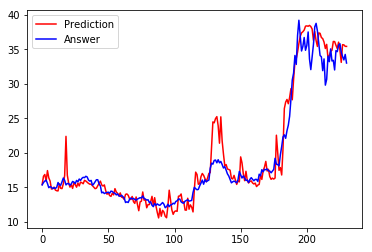

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()